### Word Frequency

In [146]:
import string
import pandas as pd
import numpy as np
import nltk
import re
from itertools import combinations, product
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
translator = str.maketrans('', '', string.punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stevenoluwaniyi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1 & 2

We developed a scraper called "scrappy" that lives in the scrappy folder.

In [147]:
df = pd.read_csv('./scrappy/scrappy_do.csv')
df = df[0:5000] # first 5000
df.head()

,date,userid,message
0,2002-03-25T05:54:02+00:00,merc1,I personally think that with a few tweaks the ...
1,2002-03-25T07:06:29+00:00,fredvh,I am debating a new purchase and these two are...
2,2002-03-25T17:02:27+00:00,blueguydotcom,"Great handling, RWD, excellent engine and the ..."
3,2002-03-25T23:04:37+00:00,hungrywhale,And no manual tranny. That may not matter to y...
4,2002-03-26T00:44:13+00:00,riez,One beauty of BMW 3 Series is that there are s...


### 3

In [148]:
modelsDF = pd.read_csv('./models.csv', names=['make', 'model'])
# this dataframe contains some other mappings like seat => seats
# for the makes / models will we ignore those, they are at the end
makemodels = modelsDF[0:520]

def wordCount(post):
    d = {}
    l = str(post).lower().translate(translator).split(" ")
    filtered = [w for w in l if w not in stop_words]
    for w in filtered:
        d[w] = 1 if not d.get(w) else d[w] + 1
    return d

allText = ' '.join(list(map(lambda x: str(x), list(df['message']))))
counts = wordCount(allText)

def extractMakes(wordCounts):
    makes = {}
    for make in makemodels['make']:
        if wordCounts.get(make):
            makes[make] = wordCounts[make]
    return makes

def combineModels(makes, wordCounts):
    for row in makemodels.iterrows():
        make = row[1].make
        model = row[1].model
        if wordCounts.get(model):
            makes[make] += wordCounts.get(model)
    return makes
    
carCounts = combineModels(extractMakes(counts), counts)
carCounts = [(k, v) for k, v in carCounts.items()]
carCounts.sort(key=lambda x: x[1], reverse=True)
display(carCounts)

top10 = list(map(lambda c: c[0], carCounts[0:10]))
print('Top 10: {}'.format(top10))

[('bmw', 2430),
 ('acura', 793),
 ('audi', 780),
 ('honda', 637),
 ('toyota', 522),
 ('infiniti', 515),
 ('nissan', 468),
 ('volkswagen', 416),
 ('subaru', 351),
 ('chevrolet', 209),
 ('mercedes', 206),
 ('volvo', 195),
 ('ford', 190),
 ('hyundai', 187),
 ('mazda', 91),
 ('cadillac', 89),
 ('chrysler', 81),
 ('dodge', 65),
 ('pontiac', 65),
 ('lincoln', 58),
 ('buick', 30),
 ('kia', 25),
 ('mitsubishi', 24),
 ('suzuki', 18),
 ('mercury', 16),
 ('saturn', 12)]

Top 10: ['bmw', 'acura', 'audi', 'honda', 'toyota', 'infiniti', 'nissan', 'volkswagen', 'subaru', 'chevrolet']


In [149]:
# Task C.

modelWords = list(modelsDF['make'].unique()) + list(modelsDF['model'].unique())

countTuple = [(k, v) for k, v in counts.items()]
filtered = list(filter(lambda x: x[0] not in modelWords, countTuple))

filtered.sort(key=lambda x: x[1], reverse=True)
display('Example attributes sorted:', filtered[0:20])

attributes = ['performance', 'luxury', 'power', 'handling', 'speed']
print('Selected attributes are:', attributes)

'Example attributes sorted:'

[('', 3119),
 ('like', 1775),
 ('tl', 1678),
 ('one', 1472),
 ('would', 1417),
 ('dont', 1360),
 ('get', 1278),
 ('g35', 1223),
 ('think', 1195),
 ('better', 956),
 ('drive', 956),
 ('new', 921),
 ('much', 903),
 ('im', 899),
 ('performance', 885),
 ('3', 849),
 ('even', 840),
 ('people', 821),
 ('good', 797),
 ('really', 760)]

Selected attributes are: ['performance', 'luxury', 'power', 'handling', 'speed']


### Task A.

In [150]:
def splitReplace(post):
    post = str(post).lower()
    
    post = post.translate(translator)
    modelKeys = model_to_make.keys()
    wordList = post.split(' ')
    
    for idx, word in enumerate(wordList):
        if word in modelKeys:
            wordList[idx] = model_to_make.get(word)
            
    unique = list(set(wordList))
    return unique if len(unique) else []
    

postsDF['words'] = postsDF['message'].map(lambda x: splitReplace(x))

In [151]:
def do_lift(x, y=None):
    l1, l2 = sorted(x), sorted(y or [])
    bools = pd.DataFrame()
    for e in l1 + l2:
        bools[e] = postsDF['words'].map(lambda words: e in words)

    def do(df, a, b):
        count_a_int_b = np.logical_and(df[a], df[b]).values.sum()
        count_a_mult_count_b = df[a].values.sum() * df[b].values.sum()
        return len(df.index) * count_a_int_b / count_a_mult_count_b

    result_df = pd.DataFrame(index=l1, columns=(l2 or l1))
    for a, b in (combinations(l1, 2) if y==None else product(l1, l2)):
        val = do(bools, a, b)
        result_df.at[a, b] = val
        if y==None:
            result_df.at[b, a] = val

    return result_df

In [152]:
do_lift(top10)

,acura,audi,bmw,chevrolet,honda,infiniti,nissan,subaru,toyota,volkswagen
acura,NaN,2.25881,1.35088,1.34404,3.25366,3.17498,1.99418,1.6468,1.72194,1.72271
audi,2.25881,NaN,1.66233,1.58915,1.71347,2.43379,1.23376,1.53754,1.57082,3.34349
bmw,1.35088,1.66233,NaN,1.38111,1.18766,1.80204,1.25842,1.19879,1.4399,1.28244
chevrolet,1.34404,1.58915,1.38111,NaN,1.84124,1.51297,2.77944,2.14877,2.54244,2.41639
honda,3.25366,1.71347,1.18766,1.84124,NaN,1.50261,3.15628,1.8132,3.4366,2.37887
infiniti,3.17498,2.43379,1.80204,1.51297,1.50261,NaN,3.46296,1.6095,1.81368,1.72915
nissan,1.99418,1.23376,1.25842,2.77944,3.15628,3.46296,NaN,2.3052,4.11521,2.52408
subaru,1.6468,1.53754,1.19879,2.14877,1.8132,1.6095,2.3052,NaN,1.65967,2.8731
toyota,1.72194,1.57082,1.4399,2.54244,3.4366,1.81368,4.11521,1.65967,NaN,2.08856
volkswagen,1.72271,3.34349,1.28244,2.41639,2.37887,1.72915,2.52408,2.8731,2.08856,NaN


### Task B.
##### Insights

In [153]:
# Task C.

modelWords = list(modelsDF['make'].unique()) + list(modelsDF['model'].unique())

countTuple = [(k, v) for k, v in counts.items()]
filtered = list(filter(lambda x: x[0] not in modelWords, countTuple))

filtered.sort(key=lambda x: x[1], reverse=True)
display('Example attributes sorted:', filtered[0:20])

attributes = ['performance', 'luxury', 'power', 'handling', 'speed']
print('Selected attributes are:', attributes)

'Example attributes sorted:'

[('', 3119),
 ('like', 1775),
 ('tl', 1678),
 ('one', 1472),
 ('would', 1417),
 ('dont', 1360),
 ('get', 1278),
 ('g35', 1223),
 ('think', 1195),
 ('better', 956),
 ('drive', 956),
 ('new', 921),
 ('much', 903),
 ('im', 899),
 ('performance', 885),
 ('3', 849),
 ('even', 840),
 ('people', 821),
 ('good', 797),
 ('really', 760)]

Selected attributes are: ['performance', 'luxury', 'power', 'handling', 'speed']


### Continue Tasks

In [154]:
top_10_brands = do_lift(top10)

In [155]:
topBrandsList = list(top_10_brands.columns)

In [156]:
topBrandsList

['acura',
 'audi',
 'bmw',
 'chevrolet',
 'honda',
 'infiniti',
 'nissan',
 'subaru',
 'toyota',
 'volkswagen']

In [157]:
top_10_brands

,acura,audi,bmw,chevrolet,honda,infiniti,nissan,subaru,toyota,volkswagen
acura,NaN,2.25881,1.35088,1.34404,3.25366,3.17498,1.99418,1.6468,1.72194,1.72271
audi,2.25881,NaN,1.66233,1.58915,1.71347,2.43379,1.23376,1.53754,1.57082,3.34349
bmw,1.35088,1.66233,NaN,1.38111,1.18766,1.80204,1.25842,1.19879,1.4399,1.28244
chevrolet,1.34404,1.58915,1.38111,NaN,1.84124,1.51297,2.77944,2.14877,2.54244,2.41639
honda,3.25366,1.71347,1.18766,1.84124,NaN,1.50261,3.15628,1.8132,3.4366,2.37887
infiniti,3.17498,2.43379,1.80204,1.51297,1.50261,NaN,3.46296,1.6095,1.81368,1.72915
nissan,1.99418,1.23376,1.25842,2.77944,3.15628,3.46296,NaN,2.3052,4.11521,2.52408
subaru,1.6468,1.53754,1.19879,2.14877,1.8132,1.6095,2.3052,NaN,1.65967,2.8731
toyota,1.72194,1.57082,1.4399,2.54244,3.4366,1.81368,4.11521,1.65967,NaN,2.08856
volkswagen,1.72271,3.34349,1.28244,2.41639,2.37887,1.72915,2.52408,2.8731,2.08856,NaN


In [158]:
do_lift(top10[0:5], ['love', 'aspire', 'want', 'dream', 'wish'])

,aspire,dream,love,want,wish
acura,1.78085,1.31374,1.87146,1.51717,1.34805
audi,3.79012,2.11818,2.05819,1.86406,1.92183
bmw,2.46141,2.07689,1.59364,1.61774,1.57191
honda,2.34205,1.15183,1.89126,1.57382,1.5396
toyota,3.67498,1.50614,1.26023,2.0677,1.68376


In [159]:
dissimilarity_matrix = 1/top_10_brands
np.fill_diagonal(dissimilarity_matrix.values, 0)
dissimilarity_matrix

,acura,audi,bmw,chevrolet,honda,infiniti,nissan,subaru,toyota,volkswagen
acura,0,0.442711,0.740256,0.744028,0.307347,0.314962,0.50146,0.607237,0.580741,0.580482
audi,0.442711,0,0.601564,0.629267,0.583611,0.410882,0.810528,0.650391,0.636612,0.299089
bmw,0.740256,0.601564,0,0.724057,0.841993,0.554926,0.794649,0.834176,0.694491,0.779764
chevrolet,0.744028,0.629267,0.724057,0,0.543113,0.660951,0.359785,0.465382,0.393323,0.41384
honda,0.307347,0.583611,0.841993,0.543113,0,0.665507,0.316828,0.55151,0.290985,0.420368
infiniti,0.314962,0.410882,0.554926,0.660951,0.665507,0,0.28877,0.621311,0.551364,0.578317
nissan,0.50146,0.810528,0.794649,0.359785,0.316828,0.28877,0,0.433802,0.243001,0.396183
subaru,0.607237,0.650391,0.834176,0.465382,0.55151,0.621311,0.433802,0,0.60253,0.348056
toyota,0.580741,0.636612,0.694491,0.393323,0.290985,0.551364,0.243001,0.60253,0,0.478799
volkswagen,0.580482,0.299089,0.779764,0.41384,0.420368,0.578317,0.396183,0.348056,0.478799,0


In [160]:
# Plotting MDS plot
from sklearn import manifold
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
      random_state=seed, dissimilarity="precomputed", n_jobs=1)
results = mds.fit(dissimilarity_matrix)
coords = results.embedding_

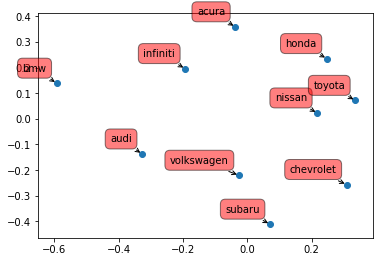

In [161]:
import matplotlib.pyplot as plt
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
for label, x, y in zip(topBrandsList, coords[:, 0], coords[:, 1]):
    
    plt.annotate(
        label,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'red', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

In [145]:
do_lift(top10[0:5], importantWords)

,handling,luxury,performance,power,speed
acura,1.6829,2.03727,1.62576,1.85756,1.83004
audi,1.85199,1.89727,1.73898,1.93522,1.84652
bmw,1.79176,1.46202,1.62448,1.62643,1.3359
honda,1.67457,1.97196,1.51231,1.80006,1.95387
toyota,2.46224,2.7467,1.90022,1.58297,1.52278
